In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import log_loss, classification_report
%matplotlib inline

In [2]:
sql_connect = sqlite3.connect('starbucks.db')
cursor = sql_connect.cursor()

In [3]:
combine_df = pd.read_sql_query("SELECT * from combine_df", sql_connect)

## Change `became_member_on` to date difference between min `became_member_on`

In [4]:
min_became_member_on = pd.to_datetime(combine_df['became_member_on']).min()
combine_df['became_member_on'] = (pd.to_datetime(combine_df['became_member_on']) - min_became_member_on).astype('timedelta64[D]')

## OHE for `offer_type` and `gender`

In [5]:
combine_df = pd.concat([combine_df, pd.get_dummies(combine_df[['offer_type', 'gender']], drop_first=True)], axis=1)

In [6]:
combine_df.drop(columns=['offer_type', 'gender'], inplace=True)

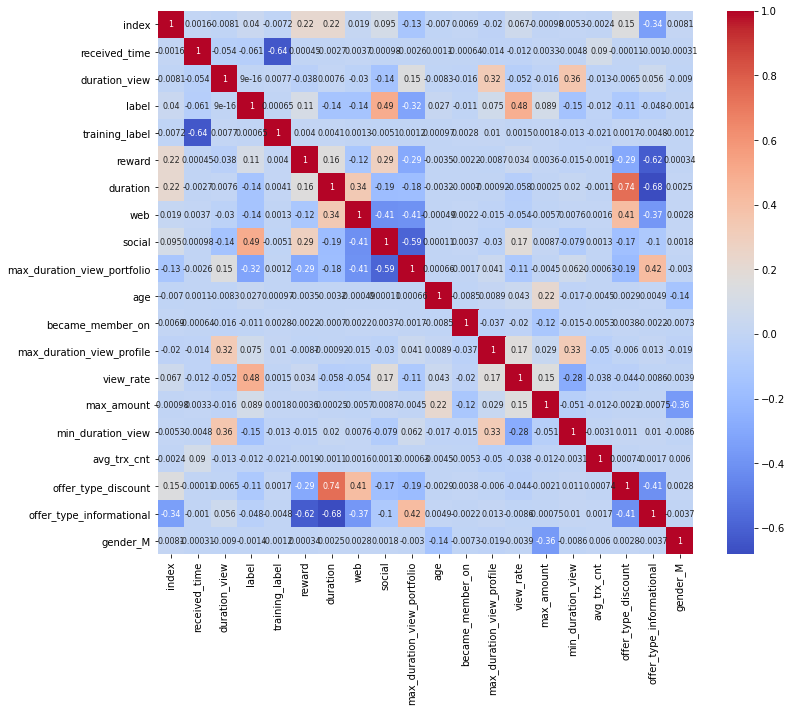

In [7]:
fig, ax = plt.subplots(figsize=(12,10))
corr = combine_df.corr()
#plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,
        cmap="coolwarm",
        annot_kws={"fontsize":8});

In [8]:
combine_df.columns

Index(['index', 'person', 'offer_id', 'received_time', 'duration_view',
       'label', 'training_label', 'reward', 'duration', 'web', 'social',
       'max_duration_view_portfolio', 'age', 'became_member_on',
       'max_duration_view_profile', 'view_rate', 'max_amount',
       'min_duration_view', 'avg_trx_cnt', 'offer_type_discount',
       'offer_type_informational', 'gender_M'],
      dtype='object')

In [9]:
feat = ['duration_view','reward', 'duration', 'web', 'social',
       'max_duration_view_portfolio', 'age', 'became_member_on',
       'max_duration_view_profile', 'view_rate', 'max_amount',
       'min_duration_view', 'avg_trx_cnt', 'offer_type_discount',
       'offer_type_informational', 'gender_M']

In [10]:
training_df = combine_df[combine_df['training_label'] == 1]
testing_df = combine_df[combine_df['training_label'] == 0]

## Modeling

### Hybrid GBDT (LightGBM) & LR model
- Create tree-based features using GBDT
   - each individual tree is a categorical feature that takes as value the index of the leaf an instance ends up falling in
- Classify using Logistic Regression on features including both original features and features created by GBDT

#### Split traing and validation set

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(training_df[feat], training_df.label, 
                                                      test_size=0.3, random_state=2021, stratify = training_df.label)
X_test = testing_df[feat]

#### Hyperparameter optimization with bayesian optimization

In [12]:
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=0, n_estimators=1000, learning_rate=0.05, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    
    # parameters
    def lgb_eval(learning_rate, num_leaves, feature_fraction, max_depth , min_split_gain, min_child_weight):
        params = {
            "objective" : "regression", 
            "bagging_fraction" : 0.2, 
            "bagging_freq": 1,
            "min_child_samples": 20, 
            "reg_alpha": 1, 
            "reg_lambda": 1,
            "boosting": "gbdt",
            "learning_rate" : 0.01, 
            "subsample" : 0.8, 
            "colsample_bytree" : 0.8, 
            "verbosity": -1, 
            "metric" : 'binary_logloss'
        }
        
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['num_leaves'] = int(round(num_leaves))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, verbose_eval =200,stratified=False)
        
        return (-1.0 * np.array(cv_result['binary_logloss-mean'])).max()
    
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'feature_fraction': (0.1, 0.9),
                                            'max_depth': (5, 9),
                                            'num_leaves' : (200,300),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round,acq='ei')

    # output optimization process
    if output_process: 
        lgbBO.points_to_csv("bayes_opt_result.csv")

    # return best parameters
    return max(lgbBO.res, key=lambda x:x['target'])['params']

opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round=10, opt_round=10, n_folds=5, random_seed=0, n_estimators=1000, learning_rate=0.01)

|   iter    |  target   | featur... | learni... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.8 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.5390508031418598, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.5390508031418598
|  1        | -0.005181 |  0.5391   |  0.718    |  7.411    |  29.52    |  0.04294  |  264.6    |
|  2        | -0.01198  |  0.4501   |  0.8929   |  8.855    |  22.25    |  0.07938  |  252.9    |
|  3        | -0.00157  |  0.5544   |  0.9263   |  5.284    |  8.921    |  0.003002 |  283.3    |
|  4        | -0.005211 |  0.7225   |  0.8713   |  8.914    |  40.96    |  0.04669  |  278.1    |
|  5        | -0.002898 |  0.1946   |  0.6435   |  5.573    |  47.51    |  0.05266  |  241.5    |
|  6        | -0.004812 |  0.3116   |  0.77

In [13]:
print('optimized hyperparameters: \n{}'.format(opt_params))

optimized hyperparameters: 
{'feature_fraction': 0.1307162158663382, 'learning_rate': 0.9702563297431458, 'max_depth': 5.829297958271037, 'min_child_weight': 20.522828488291005, 'min_split_gain': 0.016106434886416603, 'num_leaves': 293.3193065238089}


#### Train model with optimized hyperparameter

In [14]:
# Create LightGBM model
gbm = lgb.LGBMRegressor(objective='binary',
                        feature_fraction=0.13,
                        learning_rate=0.97,
                        max_depth = 6,
                        min_child_weight=21,
                        min_split_gain=0.016,
                        num_leaves=293)

In [15]:
# train model
gbm.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_valid, y_valid)],
        eval_names = ['train', 'val'],
        eval_metric = 'binary_logloss',
        )

[1]	train's binary_logloss: 0.0727224	val's binary_logloss: 0.0727232
[2]	train's binary_logloss: 0.0427824	val's binary_logloss: 0.0429053
[3]	train's binary_logloss: 0.0371883	val's binary_logloss: 0.0372821
[4]	train's binary_logloss: 0.0255452	val's binary_logloss: 0.0256411
[5]	train's binary_logloss: 0.0252575	val's binary_logloss: 0.025445
[6]	train's binary_logloss: 0.00914145	val's binary_logloss: 0.00921357
[7]	train's binary_logloss: 0.00898942	val's binary_logloss: 0.00908346
[8]	train's binary_logloss: 0.00896054	val's binary_logloss: 0.00907064
[9]	train's binary_logloss: 0.00823101	val's binary_logloss: 0.00832724
[10]	train's binary_logloss: 0.00815832	val's binary_logloss: 0.00825098
[11]	train's binary_logloss: 0.00814633	val's binary_logloss: 0.00824337
[12]	train's binary_logloss: 0.00813966	val's binary_logloss: 0.00824702
[13]	train's binary_logloss: 0.00813825	val's binary_logloss: 0.00824771
[14]	train's binary_logloss: 0.008133	val's binary_logloss: 0.00826317


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.13, importance_type='split', learning_rate=0.97,
       max_depth=6, min_child_samples=20, min_child_weight=21,
       min_split_gain=0.016, n_estimators=100, n_jobs=-1, num_leaves=293,
       objective='binary', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [16]:
model = gbm.booster_

#### Create tree-based features

In [18]:
def create_tree_based_features(model, df, feat):
    # Create tree-based features with trained GBDT
    gbdt_feats = model.predict(df[feat],pred_leaf=True)
    gbdt_feats_name = ['gbdt_leaf_' + str(i) for i in range(gbdt_feats.shape[1])]
    
    # Perform one-hot encoding on features created by GBDT
    gbdt_feats_df = pd.DataFrame(gbdt_feats, columns = gbdt_feats_name) 
    ohe_df = pd.get_dummies(gbdt_feats_df)
    
    # Combine original features and one-hot encoding tree-based features
    return pd.concat([df[feat].reset_index(), ohe_df], axis = 1), df.label

In [19]:
X_train_hybrid, y_train_hybrid = create_tree_based_features(model,training_df, feat)
X_test_hybrid, y_test_hybrid = create_tree_based_features(model,testing_df, feat)

#### Train LR model using original and tree-based features

In [20]:
X_train_hybrid, X_valid_hybrid, y_train_hybrid, y_valid_hybrid = train_test_split(X_train_hybrid, y_train_hybrid, test_size = 0.4, random_state = 2021)

In [21]:
clf = LogisticRegressionCV(cv=5, random_state=2021, scoring='neg_log_loss').fit(X_train_hybrid, y_train_hybrid)

/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number 

/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number 

In [22]:
train_logloss = log_loss(y_train_hybrid, clf.predict_proba(X_train_hybrid)[:, 1])
print('train-logloss: ', train_logloss)

val_logloss = log_loss(y_valid_hybrid, clf.predict_proba(X_valid_hybrid)[:, 1])
print('val-logloss: ', val_logloss)

test_logloss = log_loss(y_test_hybrid, clf.predict_proba(X_test_hybrid)[:, 1])
print('test-logloss: ', test_logloss)

train-logloss:  0.001636314960383128
val-logloss:  0.0016712308824392672
test-logloss:  0.0055163162202080925


log-loss is extremely small, indicating the strong predictive power of the hybrid model.

In [23]:
y_pred = clf.predict_proba(X_test_hybrid)[:, 1]
predicted_value = [1 if pred > 0.01 else 0 for pred in y_pred]

In [24]:
print(classification_report(y_test_hybrid, predicted_value))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80      4552
           1       0.91      1.00      0.95     15436

   micro avg       0.92      0.92      0.92     19988
   macro avg       0.96      0.84      0.88     19988
weighted avg       0.93      0.92      0.92     19988



Precision, recall, and F1-score are all really high.

### GBDT-only model
Use original features only

In [25]:
train_logloss = log_loss(y_train, gbm.predict(X_train))
print('train-logloss: ', train_logloss)

val_logloss = log_loss(y_valid, gbm.predict(X_valid))
print('val-logloss: ', val_logloss)

test_logloss = log_loss(testing_df.label, gbm.predict(X_test))
print('test-logloss: ', test_logloss)

train-logloss:  0.0019097143261086894
val-logloss:  0.0019396328660369574
test-logloss:  0.010141383855782633


The log-loss for test using GBDT-only model, although small, is almost double of hybrid model's log-loss. <br>

In [26]:
y_pred = gbm.predict(X_test)
predicted_value = [1 if pred > 0.01 else 0 for pred in y_pred]
print(classification_report(testing_df.label, predicted_value))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78      4552
           1       0.90      1.00      0.95     15436

   micro avg       0.92      0.92      0.92     19988
   macro avg       0.95      0.82      0.86     19988
weighted avg       0.93      0.92      0.91     19988



F1-score is slightly lower than hybrid model.

### LR-only model
Use original features only

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(training_df[feat], training_df.label, 
                                                      test_size=0.3, random_state=2021, stratify = training_df.label)
X_test = testing_df[feat]

In [28]:
clf = LogisticRegressionCV(cv=5, random_state=2021, scoring='neg_log_loss').fit(X_train, y_train)

/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number 

/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/yingjie/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number 

In [29]:
train_logloss = log_loss(y_train, clf.predict_proba(X_train)[:, 1])
print('train-logloss: ', train_logloss)

val_logloss = log_loss(y_valid, clf.predict_proba(X_valid)[:, 1])
print('val-logloss: ', val_logloss)

test_logloss = log_loss(testing_df.label, clf.predict_proba(X_test)[:, 1])
print('test-logloss: ', test_logloss)

train-logloss:  0.24492948718637064
val-logloss:  0.246942370110646
test-logloss:  0.44260643178619685


The log-loss metrics are much higher than the other two models.

In [30]:
y_pred = clf.predict_proba(X_test)[:, 1]
predicted_value = [1 if pred > 0.01 else 0 for pred in y_pred]
print(classification_report(testing_df.label, predicted_value))

              precision    recall  f1-score   support

           0       0.84      0.03      0.06      4552
           1       0.78      1.00      0.87     15436

   micro avg       0.78      0.78      0.78     19988
   macro avg       0.81      0.52      0.47     19988
weighted avg       0.79      0.78      0.69     19988



Precision, recall, and F1-score are also low compared to the other two models.